In [145]:
from calibration_tools import *

In [147]:
from tqdm import tqdm 
from collections import defaultdict

### I. VIX Futures for $K^\text{frac}$

In [150]:
def xi0(t): 
    return 0.005 * np.exp(-8 * t) + 0.04 * (1 - np.exp(-8 * t))

In [152]:
T_vals = [1/52, 1/12, 2/12, 6/12]
no_mm = []
mm = []
mc = []
mc_upper = []
mc_lower = []

H = 0.05
alphas = [0.01, 1, 0, 0.214, 0, 0.227]
Delta = 1/12
N_quad = 50 
m = len(alphas)-1
q = 4

n = 3600
M = 100000
Y = simulate_antithetic(M, n)

cauchy = np.convolve(alphas, alphas)
comb = make_comb(len(cauchy))

for T in tqdm(T_vals, desc = "T") : 
    tau_grid, w = gauss_legendre_interval(T, Delta, N_quad)
    g_vals = compute_g_frac(tau_grid, m, alphas, H)
    G = compute_G_frac(T, tau_grid, m, H)
    xi_vals = [xi0(tau) for tau in tau_grid]
    decomposition = get_optimal_decomposition("RECORD_QF.txt", 5999)
    trajectoires, weights = generate_Z_quantized_trajectories(T, tau_grid, decomposition, H)
    trajectoires_mm, weights_mm = moment_matching_Z_frac(trajectoires, weights, q, T, tau_grid, H)  

    integrals = compute_integrals_frac(trajectoires, G, tau_grid, w, xi_vals, g_vals, H) 
    v = compute_v_frac(integrals, alphas, Delta, H) 
    future_no_mm = vix_derivatives(v, weights, flag = "future", strike = None) 
    no_mm.append(future_no_mm)

    integrals_mm = compute_integrals_frac(trajectoires_mm, G, tau_grid, w, xi_vals, g_vals, H) 
    v_mm = compute_v_frac(integrals_mm, alphas, Delta, H) 
    future_mm = vix_derivatives(v_mm, weights_mm, flag = "future", strike = None) 
    mm.append(future_mm)

    Z = simulate_Z_frac(tau_grid, T, n, Y, H)
    v_mc = compute_v_frac_mc(Z, G, cauchy, comb, tau_grid, w, xi_vals, g_vals, H, Delta)
    future_mc, _, future_mc_lower, future_mc_upper = monte_carlo(np.sqrt(v_mc))
    mc.append(future_mc) 
    mc_upper.append(future_mc_upper)
    mc_lower.append(future_mc_lower)

T: 100%|██████████████████████████████████████████| 4/4 [03:26<00:00, 51.66s/it]


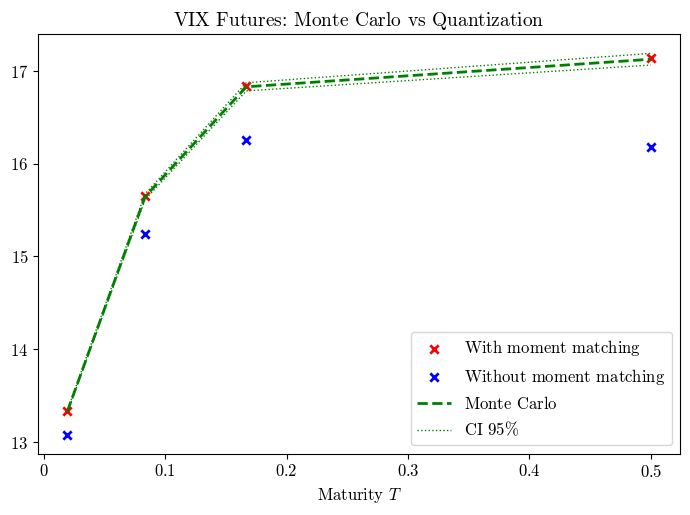

In [158]:
fig, ax = plt.subplots(figsize=(7,5.25))

ax.scatter(T_vals, mm, color="red", marker="x", label = r"$\text{With moment matching}$", linewidths=2)
ax.scatter(T_vals, no_mm, color="blue", marker="x", label = r"$\text{Without moment matching}$", linewidths=2)
ax.plot(T_vals, mc, color="green", linestyle="--", label = r"$\text{Monte Carlo}$", lw=2)
ax.plot(T_vals, mc_lower, color="green", linestyle=":", lw=1, label = r"$\text{CI }95\%$")
ax.plot(T_vals, mc_upper, color="green", linestyle=":", lw=1)

ax.set_xlabel(r"$\text{Maturity }T$", fontsize=12)
ax.set_title(r"$\text{VIX Futures: Monte Carlo vs Quantization}$", fontsize=14)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.tick_params(axis="both", labelsize=12)

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

### II. Implied volatility for $K^\text{frac}$ (Monte Carlo vs Quantization) 

In [160]:
K_grid = {
    1/52: np.linspace(12.3, 20.3, 100),
    1/12: np.linspace(13.7, 28.0, 100),
    2/12: np.linspace(14.0, 30.0, 100),
    6/12: np.linspace(14.0, 30.0, 100),
}

iv_mid = {}       
iv_mid_mm = {}     
iv_mc = {}
iv_mc_lower = {}
iv_mc_upper = {}

H = 0.05
alphas = [0.01, 1, 0, 0.214, 0, 0.227]
Delta = 1/12
N_quad = 50
m = len(alphas) - 1
q = 4

n = 3600
M = 100000
Y = simulate_antithetic(M, n)

cauchy = np.convolve(alphas, alphas)
comb = make_comb(len(cauchy))

T_vals = [1/52, 1/12, 2/12, 6/12]

for T in tqdm(T_vals, desc="T"):
    tau_grid, w = gauss_legendre_interval(T, Delta, N_quad)
    g_vals = compute_g_frac(tau_grid, m, alphas, H)
    G = compute_G_frac(T, tau_grid, m, H)
    xi_vals = [xi0(tau) for tau in tau_grid]

    Z = simulate_Z_frac(tau_grid, T, n, Y, H)
    v_mc_paths = compute_v_frac_mc(Z, G, cauchy, comb, tau_grid, w, xi_vals, g_vals, H, Delta)

    futures_mc, _, futures_mc_lower_T, futures_mc_upper_T = monte_carlo(np.sqrt(v_mc_paths))

    decomposition = get_optimal_decomposition("RECORD_QF.txt", 5999)
    trajectoires, weights = generate_Z_quantized_trajectories(T, tau_grid, decomposition, H)

    trajectoires_mm, weights_mm = moment_matching_Z_frac(trajectoires, weights, q, T, tau_grid, H)

    integrals = compute_integrals_frac(trajectoires, G, tau_grid, w, xi_vals, g_vals, H)
    v = compute_v_frac(integrals, alphas, Delta, H)
    futures = vix_derivatives(v, weights, flag="future")

    integrals_mm = compute_integrals_frac(trajectoires_mm, G, tau_grid, w, xi_vals, g_vals, H)
    v_mm = compute_v_frac(integrals_mm, alphas, Delta, H)
    futures_mm = vix_derivatives(v_mm, weights_mm, flag="future")

    K_vals = K_grid[T]
    iv_mid[T], iv_mid_mm[T] = [], []
    iv_mc[T], iv_mc_lower[T], iv_mc_upper[T] = [], [], []

    for K in K_vals :
        call = vix_derivatives(v, weights, flag="call", strike=K)

        call_mm = vix_derivatives(v_mm, weights_mm, flag="call", strike=K)

        call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(np.sqrt(v_mc_paths) - K, 0.0))

        iv_mid[T].append(safe_implied_volatility(call, futures, K, T, 0, "c"))
        iv_mid_mm[T].append(safe_implied_volatility(call_mm, futures_mm, K, T, 0, "c"))

        iv_mc[T].append(safe_implied_volatility(call_mc, futures_mc, K, T, 0, "c"))
        iv_mc_lower[T].append(safe_implied_volatility(call_mc_lower, futures_mc_lower_T, K, T, 0, "c"))
        iv_mc_upper[T].append(safe_implied_volatility(call_mc_upper, futures_mc_upper_T, K, T, 0, "c"))

T: 100%|██████████████████████████████████████████| 4/4 [03:33<00:00, 53.34s/it]


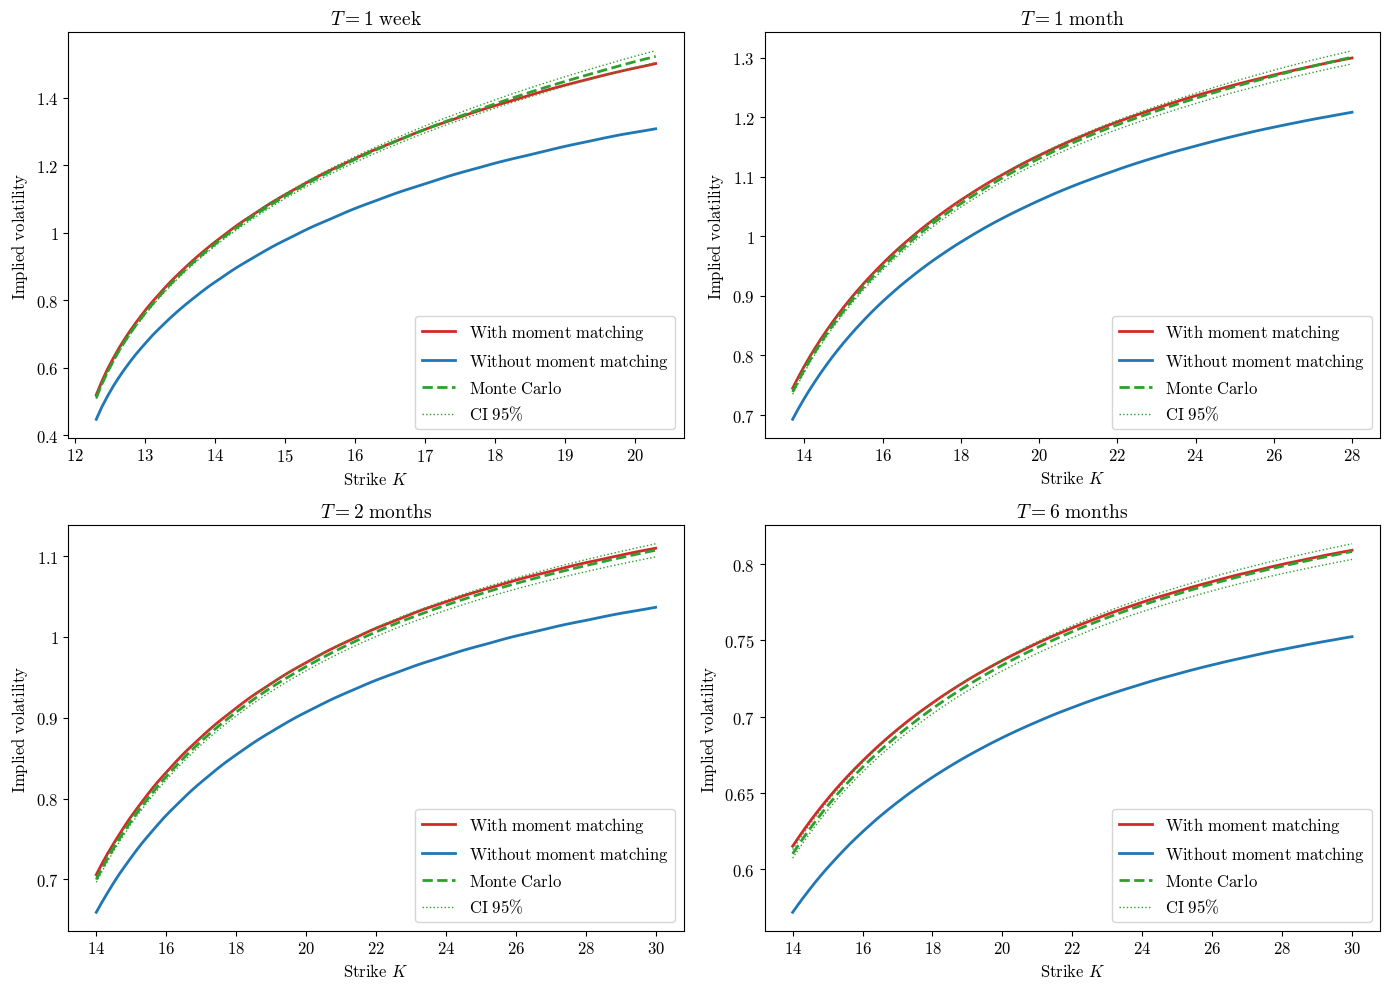

In [164]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.flatten()

titles = {
    1/52: r"$T = \mathrm{1\ week}$",
    1/12: r"$T = \mathrm{1\ month}$",
    2/12: r"$T = \mathrm{2\ months}$",
    6/12: r"$T = \mathrm{6\ months}$",
}

for j, T in enumerate(T_vals):
    a = ax[j]
    K_vals = K_grid[T]

    a.plot(K_vals, iv_mid_mm[T], color="tab:red", label=r"$\mathrm{With\ moment\ matching}$", lw=2)
    a.plot(K_vals, iv_mid[T], color="tab:blue", label=r"$\mathrm{Without\ moment\ matching}$", lw=2)
    a.plot(K_vals, iv_mc[T], color="tab:green", linestyle="--", label=r"$\mathrm{Monte\ Carlo}$", lw=2)
    a.plot(K_vals, iv_mc_lower[T], color="tab:green", lw=1, linestyle=":", label=r"$\mathrm{CI}\ 95\%$")
    a.plot(K_vals, iv_mc_upper[T], color="tab:green", lw=1, linestyle=":")

    a.set_title(titles[T], fontsize=14)
    a.set_xlabel(r"$\text{Strike }K$", fontsize=12)
    a.set_ylabel(r"$\mathrm{Implied\ volatility}$", fontsize=12)
    a.tick_params(axis="both", labelsize=12)
    a.legend(loc="lower right", fontsize=12)
    a.tick_params(axis='both', labelsize=12)
    a.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    a.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

plt.tight_layout()
plt.show()

### III. Implied volatility for $K^\text{frac}$  

In [166]:
q = 4 
Delta = 1/12
N_quad = 50 
N_vals = [50, 500, 1000, 4999] 
T_vals = [1/52, 1/12, 2/12, 6/12] 

H = 0.05
alphas = [0.01, 1, 0, 0.214, 0, 0.227]

n = 3600
M = 100000
Y = simulate_antithetic(M, n)
cauchy = np.convolve(alphas, alphas)
comb = make_comb(len(cauchy))
m = len(alphas)-1

In [168]:
iv_mm = {}               
iv_mc = {}               
iv_mc_lower = {}
iv_mc_upper = {}

K_grid = {
    1/52: np.linspace(15.2, 31, 100),
    1/12: np.linspace(14, 30, 100),
    2/12: np.linspace(14, 29, 100),
    6/12: np.linspace(13, 27, 100),
}

for T in tqdm(T_vals, desc="T"):
    tau_grid, w = gauss_legendre_interval(T, Delta, N_quad)
    xi_vals = [0.03] * len(tau_grid) 
    g_vals = compute_g_frac(tau_grid, m, alphas, H)
    G = compute_G_frac(T, tau_grid, m, H)
    Z = simulate_Z_frac(tau_grid, T, n, Y, H)

    v_mc = compute_v_frac_mc(Z, G, cauchy, comb, tau_grid, w, xi_vals, g_vals, H, Delta)

    futures_mc, _, futures_mc_lower_T, futures_mc_upper_T = monte_carlo(np.sqrt(v_mc))

    K_vals = K_grid[T]
    iv_mc[T], iv_mc_lower[T], iv_mc_upper[T] = [], [], []

    for N in N_vals:
        decomposition = get_optimal_decomposition("RECORD_QF.txt", N)
        trajectoires, weights = generate_Z_quantized_trajectories(T, tau_grid, decomposition, H)

        trajectoires_mm, weights_mm = moment_matching_Z_frac(trajectoires, weights, q, T, tau_grid, H)
        integrals_mm = compute_integrals_frac(trajectoires_mm, G, tau_grid, w, xi_vals, g_vals, H)
        v_mm = compute_v_frac(integrals_mm, alphas, Delta, H)

        futures_mm = vix_derivatives(v_mm, weights_mm, flag="future")

        key = (T, N)
        iv_mm[key] = []

        for K in K_vals:
            call_mm = vix_derivatives(v_mm, weights_mm, flag="call", strike=K)  

            call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(np.sqrt(v_mc) - K, 0.0))

            iv_mm[key].append(safe_implied_volatility(call_mm, futures_mm, K, T, 0, "c"))

            if N == N_vals[-1]:  
                iv_mc[T].append(safe_implied_volatility(call_mc, futures_mc, K, T, 0, "c"))
                iv_mc_lower[T].append(safe_implied_volatility(call_mc_lower, futures_mc_lower_T, K, T, 0, "c"))
                iv_mc_upper[T].append(safe_implied_volatility(call_mc_upper, futures_mc_upper_T, K, T, 0, "c"))

T: 100%|██████████████████████████████████████████| 4/4 [03:39<00:00, 54.99s/it]


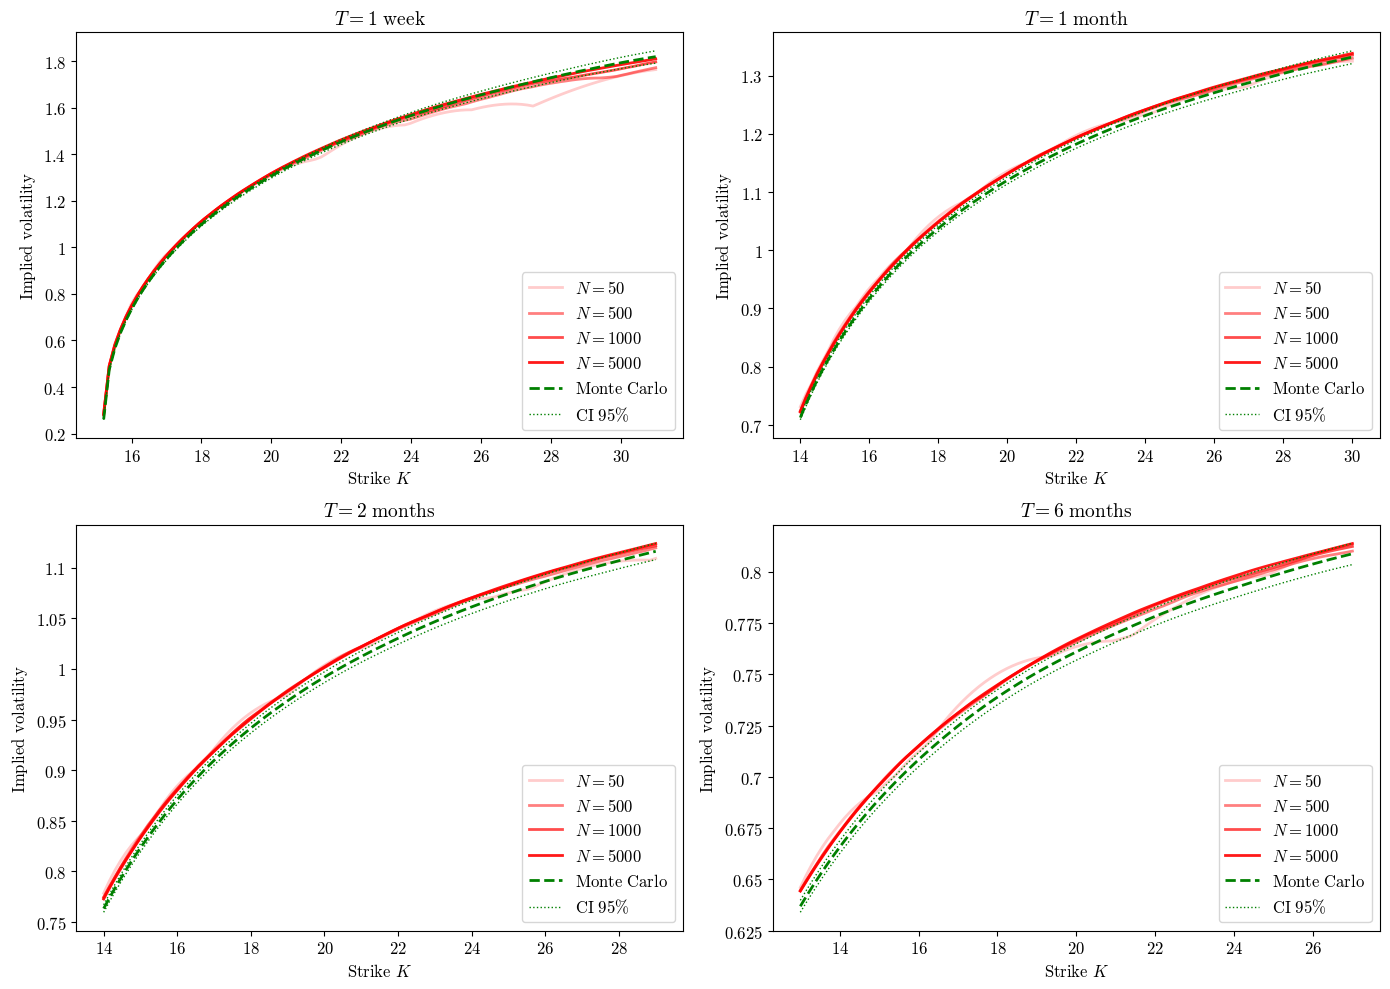

In [170]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.flatten()

titles = {
    1/52: r"$T = \mathrm{1\ week}$",
    1/12: r"$T = \mathrm{1\ month}$",
    2/12: r"$T = \mathrm{2\ months}$",
    6/12: r"$T = \mathrm{6\ months}$",
}

for j, T in enumerate(T_vals):
    K_vals = K_grid[T]
    a = ax[j]

    for N in N_vals:
        a.plot(K_vals, iv_mm[(T, N)],
               alpha={50:0.2, 500:0.5, 1000:0.7, 4999:0.9}.get(N, 0.7),
               color="red",
               lw=2,
               label=rf"$N = {N if N!=4999 else 5000}$")

    a.plot(K_vals, iv_mc[T], color="green", linestyle="--", label=r"$\mathrm{Monte\ Carlo}$", lw=2)
    a.plot(K_vals, iv_mc_lower[T], lw=1, color="green", linestyle=":", label=r"$\mathrm{CI}\ 95\%$")
    a.plot(K_vals, iv_mc_upper[T], lw=1, color="green", linestyle=":")

    a.set_title(titles[T], fontsize=14)
    a.set_xlabel(r"$\text{Strike }K$", fontsize=12)
    a.set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    a.tick_params(axis="both", labelsize=12)
    a.legend(loc="lower right", fontsize=12)
    a.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    a.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

plt.tight_layout()
plt.show()

### IV. Implied volatility for $K^\text{exp}$

In [172]:
H = -0.2
alphas = [0.01, 1, 0, 0.214, 0, 0.227]
Delta = 1/12
N_quad = 50
q = 4

eps = 1/52
m = len(alphas) - 1

N_vals = [20, 50, 100, 200, 1000]
T_vals = [1/52, 1/12, 2/12, 6/12]

K_grid = {T: (np.linspace(14.2, 30, 50) if T == 1/52 else np.linspace(14, 30, 50)) for T in T_vals}

iv_mm = {}
iv_mc = {}
iv_mc_lower = {}
iv_mc_upper = {}

for T in tqdm(T_vals, desc="T"):
    K_vals = K_grid[T]

    tau_grid, w = gauss_legendre_interval(T, Delta, N_quad)
    xi_vals = [0.03] * len(tau_grid)

    g = compute_g_exp(tau_grid, alphas, H, eps)
    G = compute_G_exp(T, tau_grid, m, H, eps)
    integrals = compute_integrals_exp(G, tau_grid, w, xi_vals, g, H, eps)

    M = 100000
    Y = simulate_antithetic(M, 50)
    sample = compute_VIX_mc(Y, integrals, alphas, Delta, H, eps, T)
    futures_mc, _, futures_mc_lower_T, futures_mc_upper_T = monte_carlo(np.sqrt(sample))

    iv_mc[T], iv_mc_lower[T], iv_mc_upper[T] = [], [], []

    for Nq in N_vals:
        weights, y = load_quantization_gaussian(f"dim_1/{Nq}_1_nopti.txt")
        y = y.ravel()

        y_mm = moment_matching_gaussian_1D(weights, y, q=q)

        v_mm = compute_v_exp(y_mm, integrals, alphas, Delta, H, eps, T)
        futures_mm = vix_derivatives(v_mm, weights, flag="future", strike=None)

        iv_mm[(T, Nq)] = []

        for K in K_vals:
            call_mm = vix_derivatives(v_mm, weights, flag="call", strike=K)
            iv_mm[(T, Nq)].append(safe_implied_volatility(call_mm, futures_mm, K, T, 0, "c"))

            if Nq == N_vals[-1]:
                call_mc, _, call_mc_lower, call_mc_upper = monte_carlo(np.maximum(np.sqrt(sample) - K, 0.0))
                iv_mc[T].append(safe_implied_volatility(call_mc, futures_mc, K, T, 0, "c"))
                iv_mc_lower[T].append(safe_implied_volatility(call_mc_lower, futures_mc_lower_T, K, T, 0, "c"))
                iv_mc_upper[T].append(safe_implied_volatility(call_mc_upper, futures_mc_upper_T, K, T, 0, "c"))

T: 100%|██████████████████████████████████████████| 4/4 [00:11<00:00,  2.79s/it]


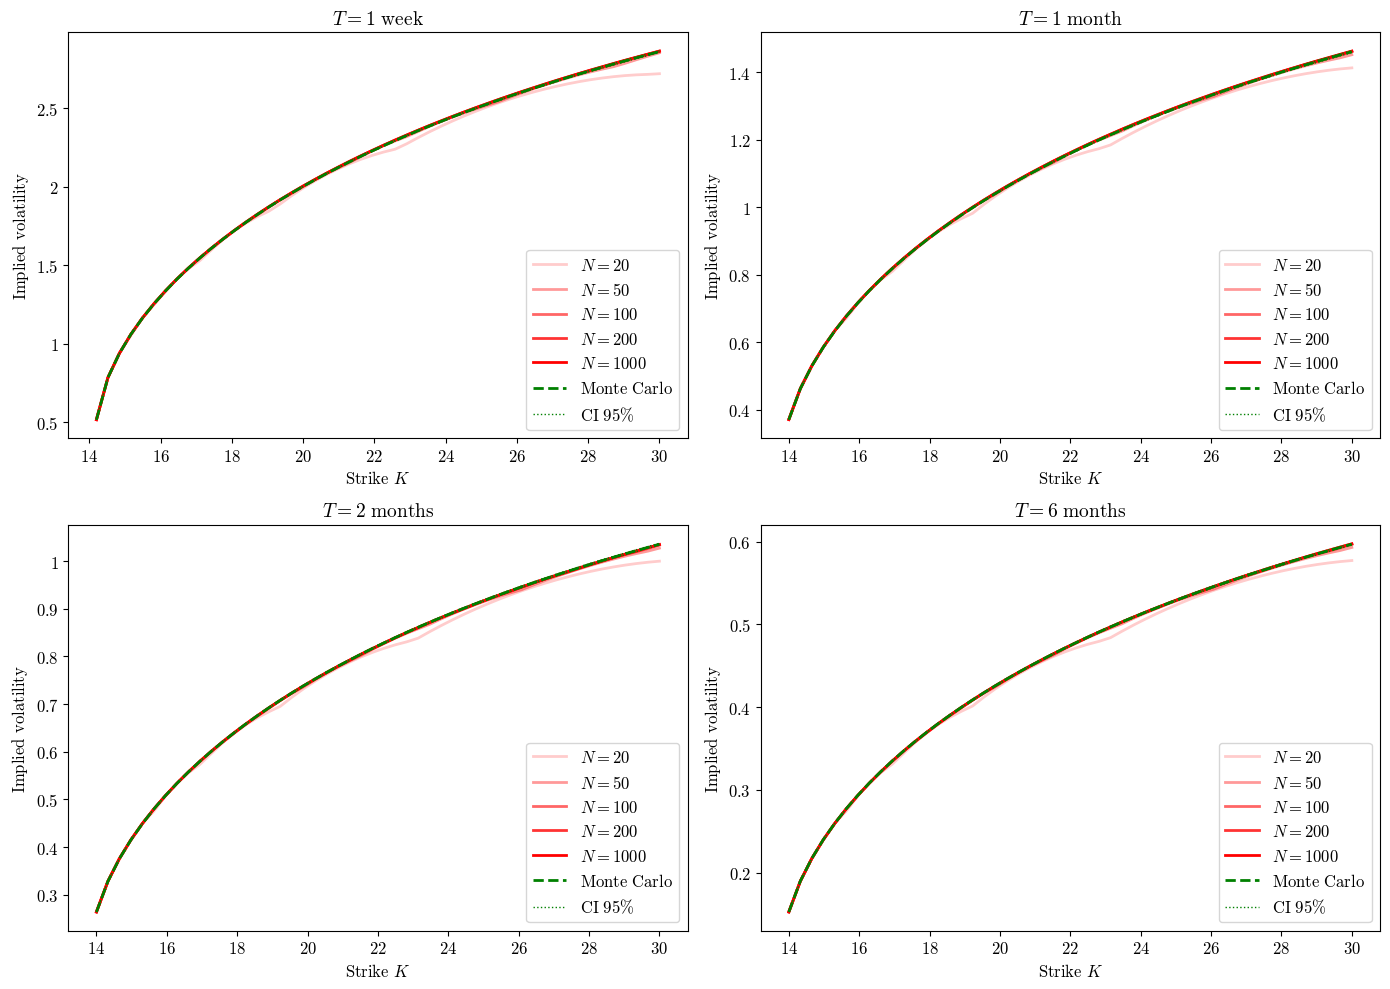

In [184]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.flatten()

titles = {
    1/52: r"$T = \mathrm{1\ week}$",
    1/12: r"$T = \mathrm{1\ month}$",
    2/12: r"$T = \mathrm{2\ months}$",
    6/12: r"$T = \mathrm{6\ months}$",
}

alpha_map = {20:0.2, 50:0.4, 100:0.6, 200:0.8, 1000:1.0}

for j, T in enumerate(T_vals):
    a = ax[j]
    K_vals = K_grid[T]

    for Nq in N_vals:
        a.plot(K_vals, iv_mm[(T, Nq)], color="red", alpha=alpha_map[Nq], label=rf"$N = {Nq}$", lw=2)

    a.plot(K_vals, iv_mc[T], color="green", linestyle="--", label=r"$\mathrm{Monte\ Carlo}$", lw=2)
    a.plot(K_vals, iv_mc_lower[T], color="green", lw=1, linestyle=":", label=r"$\mathrm{CI}\ 95\%$")
    a.plot(K_vals, iv_mc_upper[T], color="green", lw=1, linestyle=":")

    a.set_title(titles[T], fontsize=14)
    a.set_xlabel(r"$\text{Strike }K$", fontsize=12)
    a.set_ylabel(r"$\text{Implied volatility}$", fontsize=12)
    a.tick_params(axis="both", labelsize=12)
    a.legend(loc="lower right", fontsize=12)
    a.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    a.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

plt.tight_layout()
plt.show()